In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Overview**
The goal of this project is to take a set of cell images and determine which ones are cancerious vs non-cancerious.  This will be solved by building a CNN model.  The early part of this notebooks will import necessary Python packages, and do a quick EDA on the data.  

Then there will be the model section. The data set will be split 80-20 for training - validation.  The ImageDataGenerator package will be used to prepare the images for the model.  The model itself will be a multi-layer CNN model using RELU activiation functions and then Sigmoid for the output node, since this is a classification problem.  Then the model will be evaluated on typical classifier metrics( Accuracy, Precision, Recall, F1, ROC AUC), plus will have the loss and accuracy curves checked.

Finally, the choosen model will be used to predict the test sample provided by Kaggle.  The test data will have a label appended to it and a csv file of the results be created for Kaggle submission.

**Import packages**

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

**EDA Section**

In [54]:
training_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
training_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
#adjust labal to be string for modelling purposes later and add .tif extention to the end of the file names
training_labels = training_labels.astype({'id':str,'label': str })
training_labels['id'] = training_labels['id'].apply(lambda x: x + '.tif')

In [8]:
training_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [9]:
training_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


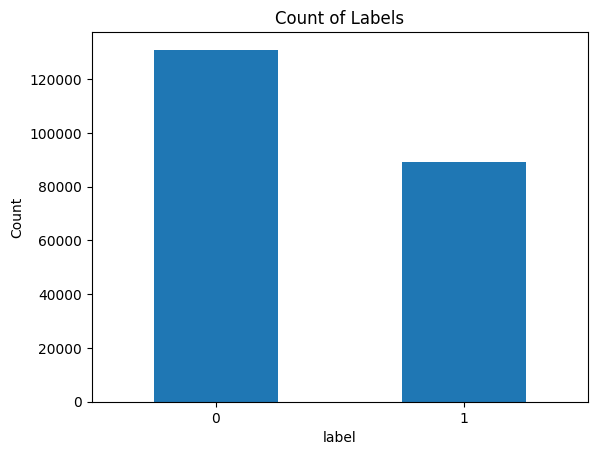

In [10]:
training_labels['label'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Count of Labels')
plt.xticks(rotation=0)
plt.show()

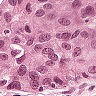

In [11]:
#view sample non-cancerous picture
Image.open('../input/histopathologic-cancer-detection/train/' + os.listdir('../input/histopathologic-cancer-detection/train')[0])

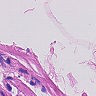

In [12]:
#view sample cancerous picture
Image.open('../input/histopathologic-cancer-detection/train/' + os.listdir('../input/histopathologic-cancer-detection/train')[1])

**Modeling**

This section will prep the images for modelling, create the CNN model structure, train and evaluate the model results

In [13]:
#Create a 20% validation data set for testing
x_train, x_val = train_test_split(training_labels, test_size=0.2, random_state=25)

In [14]:
x_train['label'].value_counts()

label
0    104714
1     71306
Name: count, dtype: int64

In [15]:
x_val['label'].value_counts()

label
0    26194
1    17811
Name: count, dtype: int64

In [16]:
#check the labels percentage of cancerious looks similar between train and validation data sets
print(71306/(71306+104714))
print(17811/(17811+26194))

0.405101692989433
0.4047494602886036


In [17]:
x_train.head()

,id,label
42571,e9936c76d94e5f8b2494b7947a901c6b8db8ca23.tif,0
186199,7dced98009f98eff437721b6b53939913897a04d.tif,0
31295,f467ec9333826c264874ec3fea8d23118c90f141.tif,0
139517,91012298990ddcffd6baaa52cdf4299fd475d5d1.tif,0
32029,3fd395a8cafa81e984aea2780c1e7bf38988976b.tif,0


In [18]:
x_val.head()

,id,label
94294,e38534cd416fe38b5f18504cfad5c3e3546a94b7.tif,1
171095,8558342bb6a6ede14c6cebdb037227010932a1d6.tif,0
3409,2e8003e10807edc75ebbcba9c52eeb48c326d215.tif,0
60887,005daeeb74d755ad47c3fe9add270f224bdcf5c4.tif,1
77609,15101051596ab3f6671b03c3a1915c6a6ec038f7.tif,0


In [19]:
data_gen = ImageDataGenerator(rescale = float(1/255), vertical_flip = True, horizontal_flip = True, rotation_range = 10, zoom_range = 0.1, height_shift_range = 0.1, width_shift_range = 0.1)

In [20]:
gen_train = data_gen.flow_from_dataframe(dataframe = x_train, directory = "../input/histopathologic-cancer-detection/train", x_col = "id", y_col = "label", batch_size = 32, seed = 25, shuffle = False, class_mode = 'binary', target_size = (96, 96))
gen_val = data_gen.flow_from_dataframe(dataframe = x_val, directory = "../input/histopathologic-cancer-detection/train", x_col = 'id', y_col = 'label', batch_size = 32, seed = 25, shuffle = False, class_mode = 'binary', target_size = (96, 96))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [35]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,486,593 (9.49 MB)

 Trainable params: 2,486,593 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
optimizer = Adam(learning_rate=0.002, beta_1=0.8, beta_2=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
hist = model.fit(gen_train, steps_per_epoch=300, validation_data=gen_val, validation_steps=75, epochs=10)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 145s 470ms/step - accuracy: 0.5891 - loss: 0.6986 - val_accuracy: 0.6008 - val_loss: 0.6161
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 139s 462ms/step - accuracy: 0.6018 - loss: 0.6202 - val_accuracy: 0.5529 - val_loss: 0.6455
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 141s 470ms/step - accuracy: 0.6815 - loss: 0.5771 - val_accuracy: 0.7788 - val_loss: 0.4740
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 140s 465ms/step - accuracy: 0.7703 - loss: 0.4979 - val_accuracy: 0.7767 - val_loss: 0.4756
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 153s 509ms/step - accuracy: 0.7643 - loss: 0.4915 - val_accuracy: 0.6925 - val_loss: 0.5794
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 455ms/step - accuracy: 0.7759 - loss: 0.4819 - val_accuracy: 0.7729 - val_loss: 0.4979
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 134s 446ms/step - accuracy: 0.7759 - loss: 0.4938 - val_accuracy: 0.7567 - val_loss: 0.5356
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 138s 460ms/step - accuracy: 0.7909 -

**Model Evaluation**

In [38]:
pred = model.predict(gen_val)
pred_binary = (pred > 0.5).astype(int).flatten()
y_true = gen_val.classes # true labels
y_pred = pred_binary[:len(y_true)]

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 333s 242ms/step


In [39]:
#check standard classification metrics
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision}')
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall}')
f1 = f1_score(y_true, y_pred)
print(f'F1: {f1}')
roc_auc = roc_auc_score(y_true, y_pred)
print(f'ROC AUC: {roc_auc}')



Accuracy: 0.8007726394727872
Precision: 0.7121013133208255
Recall: 0.8523945876143956
F1: 0.7759576806112801
ROC AUC: 0.8090330577225984


In [40]:
#set up dataframe of model results for overfitting plots
hist = pd.DataFrame(hist.history)
hist.head(5)

,accuracy,loss,val_accuracy,val_loss
0,0.592188,0.655090,0.600833,0.616107
1,0.603958,0.620459,0.552917,0.645525
2,0.724063,0.543926,0.778750,0.473958
3,0.771146,0.494833,0.776667,0.475609
4,0.766354,0.490478,0.692500,0.579404


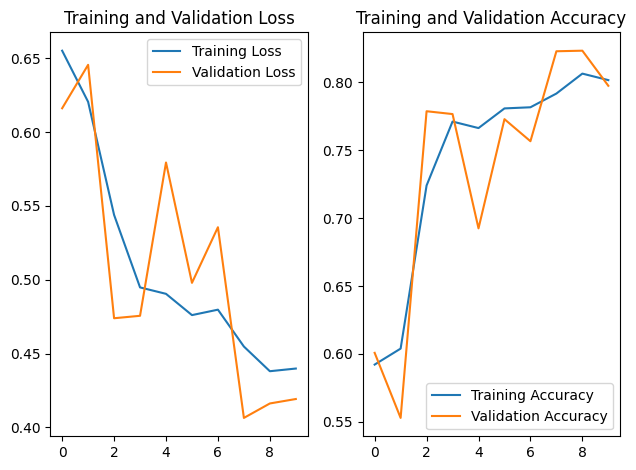

In [41]:
#check for overfitting

#Plot the loss metric
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


**Results analysis**

Overall, the model is pretty accurate with an accuracy of around 80% and an ROC AUC of 0.809.  Based on the above charts, it looks like the model was trained too long.  With the Valiation loss curve flattening / slightly going up after epoch 7. However, the plan is to keep it with the 10 epochs to see how well this model does with the Kaggle test data.  (With a little more time, I'd re-fit shortenning to 7 epochs based on the above graphs)

**Prediction File Prep**

In [43]:
#create a data frame of picture for the model to evaluate
test_path = '../input/histopathologic-cancer-detection/test'
x_test = pd.DataFrame({'id':os.listdir(test_path)})
x_test.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [46]:
data_gen_test = ImageDataGenerator(rescale = float(1/255), vertical_flip = True, horizontal_flip = True, rotation_range = 10, zoom_range = 0.1, height_shift_range = 0.1, width_shift_range = 0.1)
gen_test = data_gen_test.flow_from_dataframe(dataframe = x_test, directory = "../input/histopathologic-cancer-detection/test", x_col = "id", y_col = None, batch_size = 32, seed = 25, shuffle = False, class_mode = None, target_size = (96, 96))

Found 57458 validated image filenames.


In [47]:
y_pred_test = model.predict(gen_test)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 638s 355ms/step


In [51]:
#check that number of predictions matches the size of the test dataset
len(y_pred_test)

57458

In [52]:
y_pred_test = np.transpose(y_pred_test)[0]
#submission_df = pd.DataFrame()
x_test['id'] = x_test['id'].apply(lambda x: x.split('.')[0])
x_test['label'] = list(map(lambda x: 0 if x < 0.5 else 1, y_pred_test))
x_test.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [53]:
x_test.to_csv("submission_file.csv", index=False)